まずはデータの読み込みをした後、すべての出現単語を記録した辞書dicを作成する(辞書といいつつデータフレーム型ですすみません)。  
今後必要になるのは
- すべてのセリフを格納したserif_all
- すべての名前を格納したname_all
- すべてのタイプを格納したtype_all
- 単語を出現頻度順に並べた辞書のようなものdic(今後は単語をこの"辞書"のidに変換して扱う)

である、どのような感じかだけつかんでおけばよい。

In [17]:
import codecs
import numpy as np
import pandas
import random
import sys
from janome.tokenizer import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding

#セリフのデータを読みこむ
types = ["cute","cool","passion"]
serif_all = []
name_all = []
type_all = []#0はcute,1はcool,2はpassion
for i,type_temp in enumerate(types):#タイプごとにデータを読み込む
    filename = "./data/comment_"+type_temp+".txt"#アイドルコメントの読み込み
    file = codecs.open(filename, 'r')
    serif_all.extend(file.readlines())
    type_all.extend([i]*(len(serif_all)-len(type_all)))#serif_allの長さ-type_allの長さが注目しているタイプのセリフ数
    file.close()
    filename = "./data/name_"+type_temp+".txt"#アイドル名の読み込み
    file = codecs.open(filename,"r")
    name_all.extend(file.readlines())
    file.close()

#品詞ごとに分解する
words = [] # 単語文字列、品詞、登場回数のリスト
t = Tokenizer()
counter = 0
for i in range(len(name_all)):#まずは下準備："\n"を削除
    name_all[i] = name_all[i].replace("\n","")
    serif_all[i] = serif_all[i].replace("\n","")
    
for serif in serif_all:
    counter += 1
    print(counter,end = "\r")
    tokens = t.tokenize(serif)#品詞ごとに分解される
    for j in range(0,len(tokens)): #すべての単語についてみていく
        token = tokens[j]#ある単語に注目、jを使わないとうまくいかなかったはず
        is_new_word = True
        for i in range(len(words)):#既出単語と比較し、tokenが既出か確認
            if words[i][0] == token.surface and words[i][1] == token.part_of_speech[:2]:#tokenの単語そのものと品詞が一致していたら既出とみなす
                words[i][2] += 1#出現回数を増やす
                is_new_word = False#既出だった場合の処理
                break
        if is_new_word:#新出単語であれば
            words.append([token.surface, token.part_of_speech[:2], 1])#wordsに記録、part_of_speech[:2]になっているのはpart_of_speechが"名詞,一般,*,*"のような文字列になっているから"
# 単語情報をデータフレームに変換
dic = pandas.DataFrame(words)
dic.columns = ['words', 'parts', 'freq']#順に単語、品詞、出現頻度の情報
dic = dic.sort_values(by=['freq'], ascending=False)
dic = dic.reset_index(drop=True)#出現回数の降順にインデックスを付け直す
num_words = len(dic)
print(dic.head())
for i in range(5):#どんなふうになってるか確認
    print("type:",types[type_all[i]],"\n","name:",name_all[i],"\n","serif:",serif_all[i])

  words parts  freq
0     、    記号  8202
1     …    記号  5063
2     ！    記号  4801
3     の    助詞  4087
4     て    助詞  3968
type: cute 
 name: 島村卯月 
 serif: はじめまして、○○プロデューサーさん！ 島村卯月、17歳です。私、精一杯頑張りますから、一緒に夢叶えましょうね♪よろしくお願いしますっ！
type: cute 
 name: 島村卯月+ 
 serif: 〇〇プロデューサーさん、島村卯月です！もう覚えてもらえました？ 私、もっともっと頑張りますから、一緒に夢叶えましょうね♪
type: cute 
 name: 中野有香 
 serif: 押忍！……じゃなかった！お疲れ様ですっ！プロデューサーと言えば師匠も同然！！あたし、きっと最強のアイドルになりますから、ご指導ご鞭撻のほど、よろしくお願いします！！
type: cute 
 name: 中野有香+ 
 serif: あ、あのプロデューサー、あたし、こんな可愛い服着たの生まれて初めてです……。ちょっと恥ずかしいですけど、こういうのも悪くないかも…、ありがとうございます
type: cute 
 name: 水本ゆかり 
 serif: …水本ゆかりと申します。幼少のころよりフルートをやっていましたから、音感は良いんですよ。人前で歌ったことはありませんけれど…プロデューサーさん、ご指導、よろしくお願いします


次に辞書dicのidを利用してコーパスを作成する。このときセリフのつながりなどは全く考慮せずコーパスを作成していることに注意。一応タイプごとには分かれているので、タイプごとの言葉の傾向はとらえているかも?でもあまり期待しないほうが良い。  コーパスを作成する際は単語idのみを利用しているので数字の列にしか見えないことに注意。  
ついでにコーパスに現れる単語idから単語への変換を行う辞書id_to_wordと逆の変換を行うword_to_idを作成する。  
というか学習データをコーパスとして利用していいのか？

In [2]:
corpus = []
for i,serif in enumerate(serif_all):
    print(i,end = "\r")
    tokens = t.tokenize(serif)
    n = len(tokens)
    for j in range(n):
        dic_temp = dic[(dic['words'] == tokens[j].surface) & (dic['parts'] == tokens[j].part_of_speech[:2])]
        corpus.append(dic_temp.index[0])
corpus = np.array(corpus)
print(corpus)
print(len(corpus))
word_to_id = {}
id_to_word = {}
for i in range(len(dic)):
    word_to_id[dic.iloc[i].words] = i
    id_to_word[i] = dic.iloc[i].words
print(word_to_id)
print(id_to_word)

[882   0   8 ...  26  19   2]
146256
{'、': 0, '…': 1, '！': 2, 'の': 37, 'て': 62, 'に': 5, '。': 6, 'は': 7, '○': 1205, ' ': 9, 'た': 10, 'が': 1202, 'を': 12, 'も': 13, '？': 14, 'です': 15, 'で': 2712, 'ね': 3009, 'し': 737, 'だ': 19, 'よ': 4824, 'と': 6889, 'ー': 22, '私': 23, 'な': 3564, 'から': 25, 'ん': 4956, 'か': 27, 'ます': 28, 'ない': 117, 'さん': 30, '♪': 31, 'プロデューサー': 32, 'お': 2282, 'アイドル': 34, 'って': 35, 'っ': 36, 'この': 38, 'みんな': 39, 'わ': 7776, 'い': 655, 'けど': 731, 'へ': 44, 'う': 250, '見': 46, 'てる': 47, 'いい': 584, 'こと': 49, 'じゃ': 781, 'ふ': 51, 'たら': 5228, 'なっ': 53, '今日': 54, 'これ': 55, '☆': 56, 'アタシ': 58, 'する': 59, 'なんて': 2350, 'まし': 61, 'でも': 98, 'ファン': 64, '衣装': 66, 'き': 1153, 'あ': 241, 'くれ': 69, 'たい': 1962, 'ちゃう': 71, 'なら': 1072, 'よう': 6443, 'ステージ': 75, 'LIVE': 4050, '人': 77, 'もっと': 78, '～': 79, 'あたし': 80, 'こんな': 81, 'どう': 82, '仕事': 83, 'ちゃ': 830, 'ほら': 85, 'でしょ': 86, 'まで': 87, 'ませ': 9347, 'せ': 89, '一緒': 90, 'ば': 92, 'み': 7575, 'え': 1146, 'れ': 1181, 'ふっ': 96, 'みたい': 97, 'ください': 99, 'それ': 100, '今': 1511

CBOWを利用するためのモジュールをインポートする。ついでにハイパラも設定。

In [9]:
from common import config
from common.trainer import Trainer
from common.optimizer import Adam
from common.cbow import CBOW
from common.util import create_contexts_target,to_cpu,to_gpu
#ハイパーパラメータの設定
window_size = 5#コンテキストの範囲
hidden_size = 100#中間層のサイズ、中間層は1つのみ用いる
batch_size = 100
max_epoch = 15

CBOWを利用して単語の分散表現word_vecsを得る。

| epoch 1 |  iter 1 / 1462 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 1462 | time 5[s] | loss 4.16
| epoch 1 |  iter 41 / 1462 | time 9[s] | loss 4.15
| epoch 1 |  iter 61 / 1462 | time 15[s] | loss 4.10
| epoch 1 |  iter 81 / 1462 | time 19[s] | loss 4.00
| epoch 1 |  iter 101 / 1462 | time 24[s] | loss 3.84
| epoch 1 |  iter 121 / 1462 | time 29[s] | loss 3.68
| epoch 1 |  iter 141 / 1462 | time 34[s] | loss 3.52
| epoch 1 |  iter 161 / 1462 | time 38[s] | loss 3.40
| epoch 1 |  iter 181 / 1462 | time 43[s] | loss 3.30
| epoch 1 |  iter 201 / 1462 | time 48[s] | loss 3.22
| epoch 1 |  iter 221 / 1462 | time 52[s] | loss 3.14
| epoch 1 |  iter 241 / 1462 | time 57[s] | loss 3.10
| epoch 1 |  iter 261 / 1462 | time 62[s] | loss 3.04
| epoch 1 |  iter 281 / 1462 | time 66[s] | loss 2.99
| epoch 1 |  iter 301 / 1462 | time 71[s] | loss 2.92
| epoch 1 |  iter 321 / 1462 | time 75[s] | loss 2.90
| epoch 1 |  iter 341 / 1462 | time 80[s] | loss 2.87
| epoch 1 |  iter 361 / 1462 | time 8

| epoch 3 |  iter 21 / 1462 | time 422[s] | loss 2.41
| epoch 3 |  iter 41 / 1462 | time 424[s] | loss 2.41
| epoch 3 |  iter 61 / 1462 | time 426[s] | loss 2.40
| epoch 3 |  iter 81 / 1462 | time 428[s] | loss 2.39
| epoch 3 |  iter 101 / 1462 | time 431[s] | loss 2.39
| epoch 3 |  iter 121 / 1462 | time 433[s] | loss 2.40
| epoch 3 |  iter 141 / 1462 | time 435[s] | loss 2.39
| epoch 3 |  iter 161 / 1462 | time 437[s] | loss 2.40
| epoch 3 |  iter 181 / 1462 | time 439[s] | loss 2.37
| epoch 3 |  iter 201 / 1462 | time 441[s] | loss 2.40
| epoch 3 |  iter 221 / 1462 | time 443[s] | loss 2.39
| epoch 3 |  iter 241 / 1462 | time 445[s] | loss 2.42
| epoch 3 |  iter 261 / 1462 | time 447[s] | loss 2.41
| epoch 3 |  iter 281 / 1462 | time 449[s] | loss 2.41
| epoch 3 |  iter 301 / 1462 | time 451[s] | loss 2.38
| epoch 3 |  iter 321 / 1462 | time 453[s] | loss 2.39
| epoch 3 |  iter 341 / 1462 | time 455[s] | loss 2.38
| epoch 3 |  iter 361 / 1462 | time 458[s] | loss 2.42
| epoch 3 |  i

| epoch 5 |  iter 41 / 1462 | time 717[s] | loss 2.16
| epoch 5 |  iter 61 / 1462 | time 719[s] | loss 2.13
| epoch 5 |  iter 81 / 1462 | time 721[s] | loss 2.15
| epoch 5 |  iter 101 / 1462 | time 724[s] | loss 2.13
| epoch 5 |  iter 121 / 1462 | time 726[s] | loss 2.14
| epoch 5 |  iter 141 / 1462 | time 729[s] | loss 2.12
| epoch 5 |  iter 161 / 1462 | time 731[s] | loss 2.13
| epoch 5 |  iter 181 / 1462 | time 733[s] | loss 2.14
| epoch 5 |  iter 201 / 1462 | time 735[s] | loss 2.11
| epoch 5 |  iter 221 / 1462 | time 737[s] | loss 2.13
| epoch 5 |  iter 241 / 1462 | time 740[s] | loss 2.12
| epoch 5 |  iter 261 / 1462 | time 742[s] | loss 2.12
| epoch 5 |  iter 281 / 1462 | time 744[s] | loss 2.15
| epoch 5 |  iter 301 / 1462 | time 746[s] | loss 2.12
| epoch 5 |  iter 321 / 1462 | time 749[s] | loss 2.16
| epoch 5 |  iter 341 / 1462 | time 751[s] | loss 2.14
| epoch 5 |  iter 361 / 1462 | time 753[s] | loss 2.13
| epoch 5 |  iter 381 / 1462 | time 755[s] | loss 2.14
| epoch 5 |  

| epoch 7 |  iter 41 / 1462 | time 1039[s] | loss 1.92
| epoch 7 |  iter 61 / 1462 | time 1041[s] | loss 1.92
| epoch 7 |  iter 81 / 1462 | time 1043[s] | loss 1.90
| epoch 7 |  iter 101 / 1462 | time 1045[s] | loss 1.90
| epoch 7 |  iter 121 / 1462 | time 1047[s] | loss 1.87
| epoch 7 |  iter 141 / 1462 | time 1049[s] | loss 1.92
| epoch 7 |  iter 161 / 1462 | time 1052[s] | loss 1.93
| epoch 7 |  iter 181 / 1462 | time 1054[s] | loss 1.92
| epoch 7 |  iter 201 / 1462 | time 1056[s] | loss 1.91
| epoch 7 |  iter 221 / 1462 | time 1058[s] | loss 1.89
| epoch 7 |  iter 241 / 1462 | time 1060[s] | loss 1.91
| epoch 7 |  iter 261 / 1462 | time 1062[s] | loss 1.90
| epoch 7 |  iter 281 / 1462 | time 1064[s] | loss 1.90
| epoch 7 |  iter 301 / 1462 | time 1067[s] | loss 1.96
| epoch 7 |  iter 321 / 1462 | time 1069[s] | loss 1.90
| epoch 7 |  iter 341 / 1462 | time 1071[s] | loss 1.87
| epoch 7 |  iter 361 / 1462 | time 1073[s] | loss 1.91
| epoch 7 |  iter 381 / 1462 | time 1075[s] | loss 

| epoch 9 |  iter 1 / 1462 | time 1356[s] | loss 1.75
| epoch 9 |  iter 21 / 1462 | time 1359[s] | loss 1.72
| epoch 9 |  iter 41 / 1462 | time 1361[s] | loss 1.73
| epoch 9 |  iter 61 / 1462 | time 1363[s] | loss 1.74
| epoch 9 |  iter 81 / 1462 | time 1365[s] | loss 1.73
| epoch 9 |  iter 101 / 1462 | time 1368[s] | loss 1.73
| epoch 9 |  iter 121 / 1462 | time 1370[s] | loss 1.72
| epoch 9 |  iter 141 / 1462 | time 1372[s] | loss 1.75
| epoch 9 |  iter 161 / 1462 | time 1374[s] | loss 1.71
| epoch 9 |  iter 181 / 1462 | time 1376[s] | loss 1.73
| epoch 9 |  iter 201 / 1462 | time 1378[s] | loss 1.72
| epoch 9 |  iter 221 / 1462 | time 1380[s] | loss 1.73
| epoch 9 |  iter 241 / 1462 | time 1383[s] | loss 1.73
| epoch 9 |  iter 261 / 1462 | time 1385[s] | loss 1.76
| epoch 9 |  iter 281 / 1462 | time 1387[s] | loss 1.75
| epoch 9 |  iter 301 / 1462 | time 1389[s] | loss 1.72
| epoch 9 |  iter 321 / 1462 | time 1391[s] | loss 1.76
| epoch 9 |  iter 341 / 1462 | time 1393[s] | loss 1.7

| epoch 10 |  iter 1421 / 1462 | time 1674[s] | loss 1.67
| epoch 10 |  iter 1441 / 1462 | time 1676[s] | loss 1.68
| epoch 10 |  iter 1461 / 1462 | time 1678[s] | loss 1.69
| epoch 11 |  iter 1 / 1462 | time 1678[s] | loss 1.58
| epoch 11 |  iter 21 / 1462 | time 1680[s] | loss 1.60
| epoch 11 |  iter 41 / 1462 | time 1683[s] | loss 1.57
| epoch 11 |  iter 61 / 1462 | time 1685[s] | loss 1.61
| epoch 11 |  iter 81 / 1462 | time 1687[s] | loss 1.57
| epoch 11 |  iter 101 / 1462 | time 1689[s] | loss 1.65
| epoch 11 |  iter 121 / 1462 | time 1691[s] | loss 1.59
| epoch 11 |  iter 141 / 1462 | time 1694[s] | loss 1.59
| epoch 11 |  iter 161 / 1462 | time 1696[s] | loss 1.57
| epoch 11 |  iter 181 / 1462 | time 1698[s] | loss 1.62
| epoch 11 |  iter 201 / 1462 | time 1700[s] | loss 1.58
| epoch 11 |  iter 221 / 1462 | time 1702[s] | loss 1.60
| epoch 11 |  iter 241 / 1462 | time 1705[s] | loss 1.62
| epoch 11 |  iter 261 / 1462 | time 1707[s] | loss 1.60
| epoch 11 |  iter 281 / 1462 | ti

| epoch 12 |  iter 1341 / 1462 | time 2085[s] | loss 1.53
| epoch 12 |  iter 1361 / 1462 | time 2090[s] | loss 1.54
| epoch 12 |  iter 1381 / 1462 | time 2094[s] | loss 1.54
| epoch 12 |  iter 1401 / 1462 | time 2099[s] | loss 1.57
| epoch 12 |  iter 1421 / 1462 | time 2103[s] | loss 1.52
| epoch 12 |  iter 1441 / 1462 | time 2107[s] | loss 1.57
| epoch 12 |  iter 1461 / 1462 | time 2112[s] | loss 1.53
| epoch 13 |  iter 1 / 1462 | time 2112[s] | loss 1.49
| epoch 13 |  iter 21 / 1462 | time 2117[s] | loss 1.48
| epoch 13 |  iter 41 / 1462 | time 2121[s] | loss 1.48
| epoch 13 |  iter 61 / 1462 | time 2125[s] | loss 1.48
| epoch 13 |  iter 81 / 1462 | time 2130[s] | loss 1.44
| epoch 13 |  iter 101 / 1462 | time 2134[s] | loss 1.46
| epoch 13 |  iter 121 / 1462 | time 2138[s] | loss 1.46
| epoch 13 |  iter 141 / 1462 | time 2142[s] | loss 1.45
| epoch 13 |  iter 161 / 1462 | time 2147[s] | loss 1.47
| epoch 13 |  iter 181 / 1462 | time 2151[s] | loss 1.49
| epoch 13 |  iter 201 / 1462 

| epoch 14 |  iter 1261 / 1462 | time 2654[s] | loss 1.48
| epoch 14 |  iter 1281 / 1462 | time 2658[s] | loss 1.44
| epoch 14 |  iter 1301 / 1462 | time 2662[s] | loss 1.47
| epoch 14 |  iter 1321 / 1462 | time 2666[s] | loss 1.44
| epoch 14 |  iter 1341 / 1462 | time 2671[s] | loss 1.44
| epoch 14 |  iter 1361 / 1462 | time 2675[s] | loss 1.42
| epoch 14 |  iter 1381 / 1462 | time 2679[s] | loss 1.43
| epoch 14 |  iter 1401 / 1462 | time 2683[s] | loss 1.42
| epoch 14 |  iter 1421 / 1462 | time 2687[s] | loss 1.48
| epoch 14 |  iter 1441 / 1462 | time 2692[s] | loss 1.43
| epoch 14 |  iter 1461 / 1462 | time 2696[s] | loss 1.47
| epoch 15 |  iter 1 / 1462 | time 2696[s] | loss 1.45
| epoch 15 |  iter 21 / 1462 | time 2701[s] | loss 1.34
| epoch 15 |  iter 41 / 1462 | time 2705[s] | loss 1.37
| epoch 15 |  iter 61 / 1462 | time 2710[s] | loss 1.39
| epoch 15 |  iter 81 / 1462 | time 2714[s] | loss 1.38
| epoch 15 |  iter 101 / 1462 | time 2718[s] | loss 1.37
| epoch 15 |  iter 121 / 1

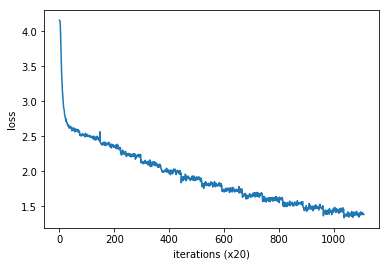

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
vocab_size  = len(dic)
contexts,target = create_contexts_target(corpus,window_size)#コーパスからコンテキストとターゲットを生成、これをもとに学習
model = CBOW(vocab_size, hidden_size, window_size, corpus)#今回は単純なCBOWを利用
optimizer = Adam()
trainer = Trainer(model,optimizer)
pkl_file = "cbow_params.pkl"
"""
既存のファイルから情報を取り出すにはこちらを利用する。
with open(pkl_file,"rb") as f:
    params = pickle.load(f)
    word_vecs = params["word_vecs"]
"""


#学習をやり直すときにはこちらを利用する必要がある。
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()
word_vecs = model.word_vecs
params = {}
params["word_vecs"] = word_vecs.astype(np.float16)
pkl_file = "cbow_params.pkl"
with open(pkl_file,"wb") as f:
    pickle.dump(params,f,-1)

単語の分散表現を利用して文章(セリフ)も分散表現にする。今回は簡単のため、文章を構成する単語の分散表現の相加平均を取ることとした。

In [12]:
serif_vec = []
i = 0
for serif in serif_all:#すべてのセリフを分散表現serif_vecに変換する。
    print(i,end = "\r")
    i += 1
    vec_temp = np.zeros(hidden_size)
    serif = serif.replace("\n","")
    tokens = t.tokenize(serif)
    for token in tokens:
        id_temp = word_to_id[token.surface]#単語の文字列からidへ
        vec_temp += word_vecs[id_temp]#idから分散表現へ
    vec_temp = vec_temp/len(tokens)#単語数で平均をとる
    serif_vec.append(vec_temp)
serif_vec = np.array(serif_vec)
print(serif_vec)

[[ 0.35976931 -0.26089809  0.37157452 ...  0.1406376   0.20921591
   0.68118968]
 [ 0.20118558 -0.17076368  0.37940715 ...  0.0771093   0.38952234
   0.76398557]
 [ 0.42471007 -0.06763237  0.40249904 ...  0.35960144  0.21314147
   0.54501253]
 ...
 [ 0.14392616  0.07147908  0.21091025 ... -0.01171696  0.22013131
   0.28453539]
 [ 0.23589497  0.29683326  0.32426843 ...  0.02831585  0.33722159
   0.26635628]
 [ 0.13961948  0.28065918  0.35524019 ...  0.31885057  0.05866565
   0.24052818]]


ランダムフォレストによるクラスタリング。入力データは文章の分散表現serif_vec,ターゲットはタイプの正解ラベルtype_allである。

In [41]:
import sklearn.ensemble
idx = np.arange(len(serif_vec))#どのように間違えたかを確認するためにこれが必要になる
idx_train,idx_test = sklearn.model_selection.train_test_split(np.arange(len(serif_vec)),test_size = 0.2)
train_x = serif_vec[idx_train]
train_y = np.array(type_all)[idx_train]
test_x = serif_vec[idx_test]
test_y = np.array(type_all)[idx_test]
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)
accuracy = model.score(train_x,train_y)
print("train:accuracy {0:.2%}".format(accuracy))
accuracy = model.score(test_x, test_y)
print('accuracy {0:.2%}'.format(accuracy))

C:\Users\yota-\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train:accuracy 98.60%
accuracy 52.10%


サポートベクタマシン(SVM)によるクラスタリング。ランダムフォレストと同じ入力を与える。なぜかわからないがSVMの方が有意に精度はよさそう。

In [57]:
from sklearn.svm import SVC
model = SVC(kernel = "linear")
model.fit(train_x,train_y)
accuracy = model.score(train_x,train_y)
print("train:accuracy {0:.2%}".format(accuracy))
accuracy = model.score(test_x,test_y)
print('test:accuracy {0:.2%}'.format(accuracy))

train:accuracy 60.18%
test:accuracy 59.44%


どのようなときに間違えているのかを確認する。

In [58]:
type_pred = model.predict(test_x)#testデータに対してprediction
idx_error = idx_test[type_pred != np.array(type_all)[idx_test]]#testデータのうち間違えていたもののindexを抽出
print(len(type_pred),len(idx_error))
type_pred_all = model.predict(serif_vec)#全体のデータに対してprediction(このあとのために仕方なく使っている)
for i,idx_temp in enumerate(idx_error):
    print("true:",types[type_all[idx_temp]],"pred:",types[type_pred_all[idx_temp]],"\n","name:",name_all[idx_temp],"\n","serif:",serif_all[idx_temp])

572 232
true: cute pred: passion 
 name: ［ムーンライトバニー］池袋晶葉+ 
 serif: ウサミミ装着っ！ さぁ祭りの始まりだ! せっかくの月見ステージなんだから派手に盛り上げるぞ！ ふっふっふ、私も自分で開発したウサちゃんロボに負ける訳にはいかないからな! 見ていてくれ！
true: cool pred: passion 
 name: ［ピッチピチ☆ピーチ］ケイト 
 serif: グッドフレグランス！　あまーい香りに誘われちゃいマスネ。今日はこの柔らかくてジューシーなpeachみたいに、私もフレッシュに岡山の魅力をトークシマス！　Hey、まずは味見からデスヨ○○プロデューサー！
true: passion pred: cute 
 name: ［セクシーサーファー］沢田麻理菜 
 serif: お仕事で沖縄に来たのにサーフィンまで楽しめちゃうなんてね。やっと〇〇くんにお姉さんのサーファー姿を見せられるわ。華麗に波を乗りこなす姿を見せて夢中にさせちゃうぞ♪
true: passion pred: cute 
 name: 槙原志保+ 
 serif: お待たせしました、アイドルしほの登場でぇす♪これからもアイドルとしてどんどん成長して、甘い甘いアイドルになりますので、よろしくお願いしますねぇ♪
true: cute pred: passion 
 name: ［ちいさなメイドさん］早坂美玲+ 
 serif: ヘヘッ、○○プロデューサー、あそこに見えるお茶屋まで来いッ！ウチより先にたどり着いたら、もてなしてやるッ！フンッ！メイド服でもなんでも、ウチはすぐに着こなしちゃうんだからなッ！ヘヘッ！
true: cool pred: cute 
 name: ［クリスマスパーティー］荒木比奈+ 
 serif: クリスマスに縁なんかなかった私が今年はサンタっスかぁ…。人生どうなるか分からないもんスね。サンタになったからには子供から大人までみんなに笑顔を届けなきゃッスね、○○プロデューサー！
true: passion pred: cute 
 name: ［テーマパーク］斉藤洋子+ 
 serif: ふふん、ちょっぴりミステリアスな私をアピールですよ、○○プロデューサー！ どうです、いつもとは違う私の魅力ビンビン伝わってくるで

 serif: ついに来ましたよっ、山奥のペンション！これほど確実に事件の起きる場所はありませんっ！全探偵、憧れの場所じゃないですか。ささ、早く入りましょう。他の名探偵に先を越されたら大変です！
true: cute pred: passion 
 name: ［桜祭り］桃井あずき+ 
 serif: 春らしい装いであずきの撮影が始まるよ！ たくさんの人にあずきの桃色パワーを見せてくるから。でもとっておきはプロデューサーさんもしっかり見逃さないでね！ 桜色大作戦そのに、スタート！
true: cute pred: cool 
 name: ［秋色温泉］江上椿+ 
 serif: 和洋折衷、この温泉郷でのLIVEにピッタリの衣装ですね。私が温泉で癒されたように私もファンのみなさんを癒してあげられるようなステージに…。○○さん、私、艶やかに咲いて参ります
true: cool pred: passion 
 name: ［熱情の魔女］川島瑞樹+ 
 serif: みんな、アツくなってるーっ？まだまだ、もっとアツくなって、声をあげなさい！うふ…いいわぁ、会場の盛り上がりで私の肌も火照ってきたみたい！もっとさらけ出して！楽しませなさい！
true: cool pred: passion 
 name: ［あやかし京娘］塩見周子 
 serif: んーコレコレ。六歳のしゅーこちゃん、かわいーでしょ？ この頃のアタシの夢、なんだと思う？ウチの和菓子屋の看板娘、だったんだ。それがいまや看板娘どころかアイドル…人生わかんないモンだよねー！
true: passion pred: cool 
 name: ［ジューンブライド］松山久美子+ 
 serif: こんなに綺麗なウエディングドレスが着れるなんて最高の気分だよ！ どーお？ 似合ってる？ ふふっ。うん、ありがと！ ○○Pは夢を叶えてくれるね！ さすが、私のプロデューサーさん！
true: cute pred: cool 
 name: 早坂美玲+ 
 serif: オマエも相当スキモノだな。本当にウチをアイドルデビューさせるなんて…。それにこういう衣装…オマエ、ウチのこと分かってるじゃないか…。な、なんだよッ！わ、笑ってるんじゃないぞこの…ガルルー！
true: cute pred: passion 
 name: ［ピーチウェ

混同行列を計算する。行が本当のタイプを表しており、列が予測されたタイプを表している。cuteの分類は難しいらしい。passionに分類されがち。半面、coolやpassionの分類は精度が高く、特にcoolとpassionを混同することは少ない。

In [66]:
confusion = np.zeros([3,3])
for i,idx_temp in enumerate(idx_test):
    confusion[type_all[idx_temp]][type_pred[i]] += 1
print(confusion)#混同行列の計算
for i in range(len(confusion)):#
    confusion[i] = confusion[i]/np.sum(confusion[i])
print(confusion)

[[ 83.  45.  69.]
 [ 35. 126.  33.]
 [ 32.  18. 131.]]
197.0
194.0
181.0
[[0.4213198  0.2284264  0.35025381]
 [0.18041237 0.64948454 0.17010309]
 [0.17679558 0.09944751 0.72375691]]
